# 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from IPython.display import Image

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family = 'malgun gothic')
mpl.rc('axes', unicode_minus = False)

sns.set_style('darkgrid')
plt.rc('figure', figsize = (10, 8))

warnings.filterwarnings('ignore')

# 데이터 로딩과 데이터 탐색

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


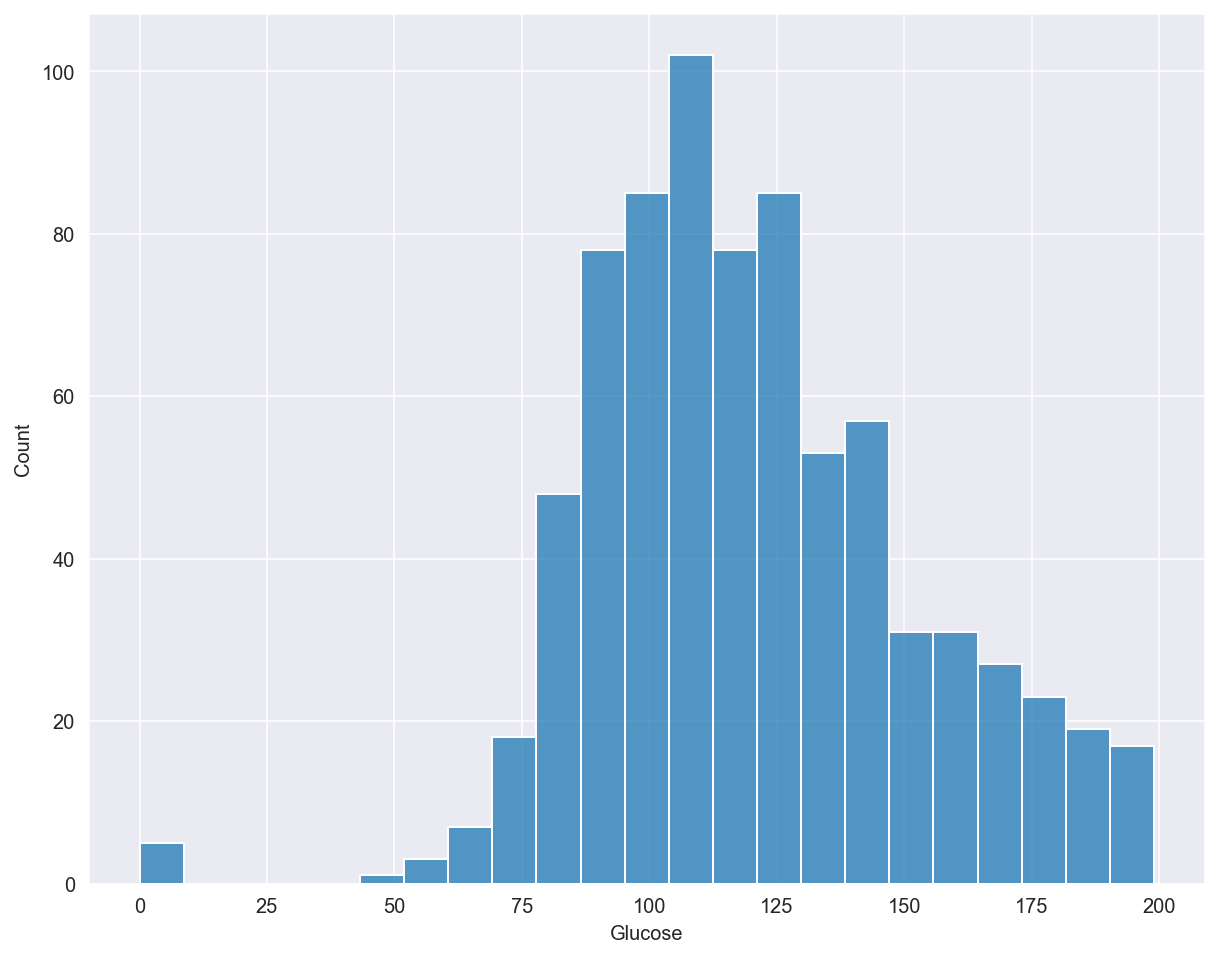

In [8]:
sns.histplot(data = diabetes, x = 'Glucose', kde = False)
plt.show()

In [9]:
diabetes['Glucose'].value_counts()[0]   ## 0 이라는 값의 건수

5

In [10]:
diabetes.count()

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

In [11]:
# 0값을 검사할 컬럼명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes.count()[0]

# 각 feature별 0값이 차지하는 비율분석
for feature in zero_features:
    zero_count = diabetes[feature].value_counts()[0]
    zero_rate = zero_count / total_count * 100
    print(f'{feature}의 건수 : {zero_count}, 퍼센트 : {zero_rate:.2f}%')

Glucose의 건수 : 5, 퍼센트 : 0.65%
BloodPressure의 건수 : 35, 퍼센트 : 4.56%
SkinThickness의 건수 : 227, 퍼센트 : 29.56%
Insulin의 건수 : 374, 퍼센트 : 48.70%
BMI의 건수 : 11, 퍼센트 : 1.43%


In [12]:
# SkinThickness, Insulin은 0값의 비율이 높아 데이터를 삭제하긴 무리가 있어 대체값이 필요해 보인다.
mean_zero_features = diabetes[zero_features].mean()
diabetes[zero_features] = diabetes[zero_features].replace(0, mean_zero_features)

# 로지스틱 회귀 모델 구현

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [14]:
X = diabetes.iloc[:, :-1]
y = diabetes.Outcome

# MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## 학습/검증 데이터 분리
- 클래스별 비율에 맞게 분리

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, 
                                                    stratify = y, random_state = 156)

## Logistic Regression

In [34]:
def  get_clf_eval(y_test, pred=None, pred_proba=None):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
 
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, \
    재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [35]:
# 모델 구현
lr = LogisticRegression()
lr.fit(X_train, y_train)
# 학습
lr.fit(X_train, y_train)
# 예측
pred = lr.predict(X_test)
pred_proba_po = lr.predict_proba(X_test)[:, 1].reshape(-1, 1)

In [36]:
cm = confusion_matrix(y_test, pred)
cm

array([[90, 10],
       [21, 33]], dtype=int64)

In [37]:
get_clf_eval(y_test, pred, pred_proba_po)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674,     재현율: 0.6111, F1: 0.6804, AUC:0.8487


## 정밀도/재현유 시각화

In [38]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_po)

In [39]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()


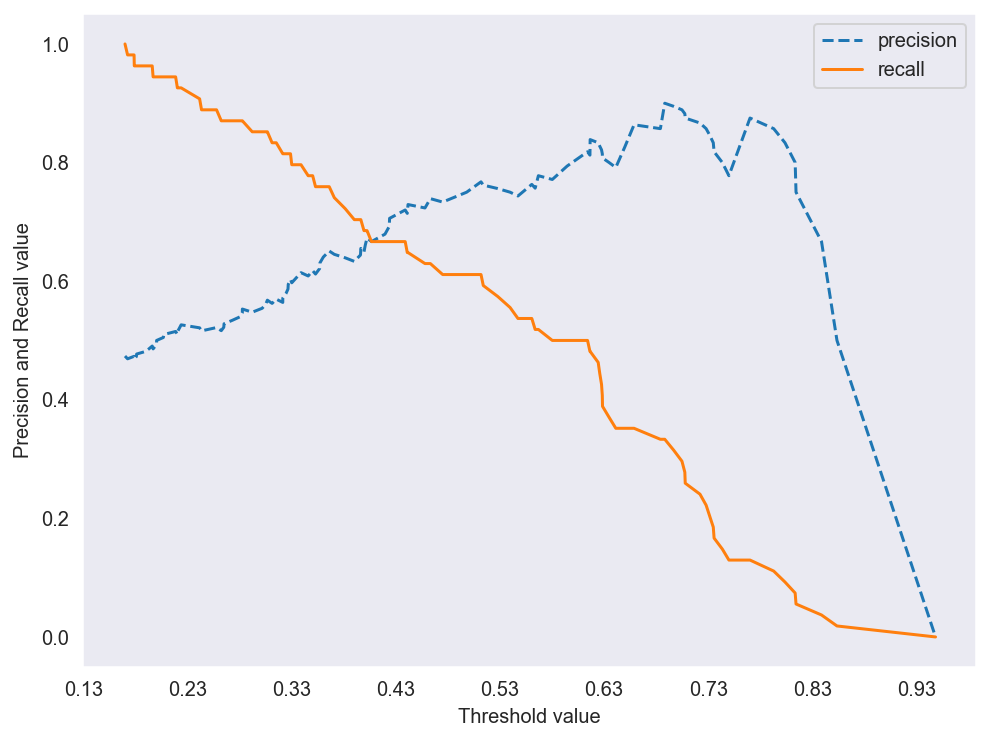

In [40]:
precision_recall_curve_plot(y_test, pred_proba_po)

### 혼돈 행렬(Confision Matrix, 오차행렬)

- TN : Negative값 0으로 예측했고, 실제값도 Negative 0인 경우의 수
- FP : Positive값 1로 예측했고, 실제값은 Negative값 0으로 나온 경우의 수
- FN : Negative값 0으로 예측했고, 실제값은 Positive값 1로 나온 경우의 수
- TP : Positive값 1로 예측했고, 실제값도 Positive값 1로 나온 경우의 수
<br><br>
1. 정확도 : 전체 데이터개수 대비 정답을 맞춘 데이터의 개수
  - Accuracy = TN + TP / TN + FP + FN + TP
<br>
2. 정밀도와 민감도 : 비슷하지만 조금 다른 지표이며 불균일한 데이터셋을 다룰 때 유용한 지표가 된다.
  - 불균일한 데이터셋이란 데이터의 1과 0의 비율이 7:3 또는 3:7 이상 차이가 나는 상태를 의미한다.
  - 정밀도(precision) : 모델이 1이라고 예측했을 때 얼마나 잘 맞는지의 비율 TP / FP + TP
  - 재현율 or 민감도(recall) : 실제 1인값을 모델이 얼마나 잘 예측했는지의 비율 TP / TP + FN
<br>
3. F1 score : 정밀도와 민감도를 통합한 지표로 정밀도와 민감도의 조화평균 값
  - 우리가 만든 모델이 얼마나 성능이 좋은지를 확인할 때 사용
  - 한개의 지표(정밀도와 재현율)를 정리할 필요가 있을 때 적합
  - 2 * (precision * recall) / (precision + recall)
<br>
<br>
- 이진분류 문제중 암에 걸렸는지 찾는 문제에서 진단이 암일 경우는 1, 암이 아닐 경우는 0을 의미한다.
- 생존 여부를 판단하는 문제에서 생존인 경우 1, 아닐 경우가 0
- 우리가 알아내려는 값이 1이 된다.

In [41]:
from sklearn.preprocessing import Binarizer

In [42]:
# def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
#     for custom_threshold in thresholds:
#         binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
#         custom_predict = binarizer.transform(pred_proba_c1)
#         print('임곗값:', custom_threshold)
#         get_clf_eval(y_test, custom_predict)

In [43]:
from sklearn.preprocessing import Binarizer

def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)

In [44]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]

In [45]:
get_clf_eval_thres(y_test, pred_proba_po, thresholds, f1_show = True, auc_show = True)

임계값,0.30,0.33,0.36,0.39,0.42,0.45,0.48,0.50
정확도,0.7078,0.7403,0.7662,0.7532,0.7792,0.7857,0.7922,0.7987
정밀도,0.5542,0.5972,0.6406,0.6333,0.6923,0.7234,0.7500,0.7674
재현율,0.8519,0.7963,0.7593,0.7037,0.6667,0.6296,0.6111,0.6111
F1스코어,0.6715,0.6825,0.6949,0.6667,0.6792,0.6733,0.6735,0.6804
AUC,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487


In [46]:
binarizer = Binarizer(threshold = 0.48)
pred048 = binarizer.fit_transform(pred_proba_po)

get_clf_eval(y_test, pred048, pred_proba_po)

오차 행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500,     재현율: 0.6111, F1: 0.6735, AUC:0.8487
